In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:

class Policy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state): # Given state, computes the prob of the actions
        x = F.relu(self.linear1(state))
        x = self.linear2(x)
        x = F.softmax(x, dim=-1)
        return x
    
    def Action(self, state): 
        '''
        Given state, samples the action according to their prob 
        and returns action and the log probability of choosing the action sampled
        '''
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.forward(state)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob


In [13]:

class Value(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        #self.hidden1  = nn.Linear(hidden_dim, hidden_dim//2)
        #self.hidden2 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        #x = F.tanh(self.hidden1(x))
        #x = F.tanh(self.hidden2(x))
        x = self.linear2(x)
        
        return x

In [14]:

def compute_return(rewards, gamma):
    G = 0
    returns = []
    
    # To compute discounted returns; Last step return and backwards
    rewards = reversed(rewards)
    for r in rewards:
        G = r + gamma*G
        returns.insert(0, G)
    
    return returns

In [15]:

gamma = 0.99
learning_rate = 0.001 # learning rate of the policy
v_learning_rate = 0.01 # learning rate of the value
hidden_dim = 256


In [16]:
def Reinforce_Baseline():
    """
    Reinforce algorithm with baseline;
    Baseline is the V(s, w){value function parameterized by w}.
    """
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    policy = Policy(state_dim, hidden_dim, action_dim).to(device)
    policy_optimizer = optim.Adam(policy.parameters(), learning_rate)
    
    value = Value(state_dim, hidden_dim, 1).to(device)
    value_optimizer = optim.Adam(value.parameters(), v_learning_rate)
    avg_reward = []
    episodic_return = [] # maintains the rewards of all episodes
    scores_window = deque(maxlen=100) # Moving window; keeps track of rewards of 100 episodes
    
    for i in range(1000): # Run for 1000 episodes
        
        state, _ = env.reset()
        
        # To keep track of the states/ rewards and log_probabilities of the trajectory
        states = []
        log_probs = []
        rewards = []
        
        t_step = 0
        done = False
        
        while not done and t_step<500:
            action, log_prob = policy.Action(state)
            
            next_state, reward, done, _, _ = env.step(action)
            
            states.append(torch.FloatTensor(state).unsqueeze(0).to(device))
            log_probs.append(log_prob)
            rewards.append(reward)
            
            state = next_state
        
        episodic_return.append(sum(rewards))
        scores_window.append(sum(rewards))
        
        states = torch.stack(states)
        
        returns = torch.tensor(compute_return(rewards, gamma), device=device) # G
        v_hat = value(states).squeeze(1) # value is instance of Value(class)
        
        delta = returns - v_hat.detach() # Adavnatge function
        
        loss = 0
        for log_prob, d in zip(log_probs, delta):
            loss+= -log_prob*d
        loss = loss.sum()
        
        policy_optimizer.zero_grad()
        loss.backward()
        policy_optimizer.step()
        
        # Updating the baseline parameters to reduce the TD error
        
        val_loss = F.mse_loss(returns, v_hat.view(-1))
        value_optimizer.zero_grad()
        val_loss.backward()
        value_optimizer.step()
        
        avg_reward.append(np.mean(scores_window))
        
        if i%10 == 0:
            print(f"Episode {i}\tAverage Return: {np.mean(scores_window):.2f}")
        if np.mean(scores_window)>=195:
            print(f"\nEnvironment solved in {i} episodes! Average Return: {np.mean(scores_window):.2f}")
            break
    
    return episodic_return, avg_reward

In [17]:

def Reinforce():
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    policy = Policy(state_dim, hidden_dim, action_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    
    scores_window = deque(maxlen=100) # Moving window; keeps track of rewards of 100 episodes
    episodic_return = [] # maintains the rewards of all episodes
    avg_reward = []
    for i in range(1000): # Run for 1000 episodes
        
        optimizer.zero_grad()
        # To keep track of the rewards/ log_prob of the trajectory
        rewards = []
        log_probs = []
        
        done  = False
        t_step = 0
        
        state, _ = env.reset()
        while not done and t_step<500:
            t_step+=1
            action, log_prob = policy.Action(state)
            
            next_state, reward, done, _, _ = env.step(action)
            
            log_probs.append(log_prob)
            rewards.append(reward)
            
            state = next_state
            
        returns = compute_return(rewards, gamma)
        
        episodic_return.append(sum(rewards))
        scores_window.append(sum(rewards))
        
        loss = 0
        for log_prob, G in zip(log_probs, returns):
            loss+= -log_prob*G
        
        loss.backward()
        optimizer.step()
        avg_reward.append(np.mean(scores_window))
        if i%10 == 0:
            print(f"Episode {i}\tAverage Return: {np.mean(scores_window):.2f}")
        if np.mean(scores_window)>=195:
            print(f"\nEnvironment solved in {i} episodes! Average Return: {np.mean(scores_window):.2f}")
            break
        
    return episodic_return, avg_reward


In [18]:
def pad(lists): 
    """
    Converts lists to numpy arrays; 
    Pads shorter runs so they can be stacked together.
    """
    max_len = max(len(l) for l in lists)
    padded = [np.pad(l, (0, max_len - len(l)), 'edge') for l in lists]
    return np.stack(padded)

In [19]:
env = gym.make("CartPole-v1")
    
Seeds = [10, 6, 2, 24, 42]

Rewards_Basline = []
Avg_Rewards_Baseline = []

Rewards = []
Avg_Rewards = []

for Seed in Seeds:
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    env.reset(seed=Seed)
    #env.action_space.seed(Seed)

    rewards, avg_reward = Reinforce()
    Rewards.append(rewards)
    Avg_Rewards.append(avg_reward)
    
    rewards_basline, avg_reward_baseline = Reinforce_Baseline()
    Rewards_Basline.append(rewards_basline)
    Avg_Rewards_Baseline.append(avg_reward_baseline)
    
    

Episode 0	Average Return: 13.00
Episode 10	Average Return: 16.36
Episode 20	Average Return: 17.43
Episode 30	Average Return: 22.65
Episode 40	Average Return: 31.10
Episode 50	Average Return: 31.00
Episode 60	Average Return: 32.39
Episode 70	Average Return: 34.06
Episode 80	Average Return: 35.72
Episode 90	Average Return: 38.41
Episode 100	Average Return: 42.12
Episode 110	Average Return: 47.48
Episode 120	Average Return: 53.85
Episode 130	Average Return: 61.52
Episode 140	Average Return: 65.74
Episode 150	Average Return: 72.50
Episode 160	Average Return: 79.43
Episode 170	Average Return: 87.40
Episode 180	Average Return: 109.83
Episode 190	Average Return: 118.32
Episode 200	Average Return: 117.82
Episode 210	Average Return: 117.94
Episode 220	Average Return: 123.80
Episode 230	Average Return: 128.90
Episode 240	Average Return: 141.82
Episode 250	Average Return: 155.21
Episode 260	Average Return: 164.84
Episode 270	Average Return: 180.23
Episode 280	Average Return: 179.37

Environment s

In [27]:
#R_Basline = [Rewards_Basline[0], Rewards_Basline[1], Rewards_Basline[2], Rewards_Basline[4]]
#Avg_R_Basline = [Avg_Rewards_Baseline[0], Avg_Rewards_Baseline[1], Avg_Rewards_Baseline[2], Avg_Rewards_Baseline[4]]
Rewards_Basline_np = pad(Rewards_Basline)
Avg_Rewards_Baseline_np = pad(Avg_Rewards_Baseline)

Rewards_np = pad(Rewards)
#Avg_R = [Avg_Rewards[0], Avg_Rewards[1], Avg_Rewards[2], Avg_Rewards[4]]
Avg_Rewards_np = pad(Avg_Rewards)

# Compute mean and std
mean_rewards_baseline = np.mean(Avg_Rewards_Baseline_np, axis=0)
std_rewards_baseline = np.std(Avg_Rewards_Baseline_np, axis=0)

mean_rewards = np.mean(Avg_Rewards_np, axis=0)
std_rewards = np.std(Avg_Rewards_np, axis=0)

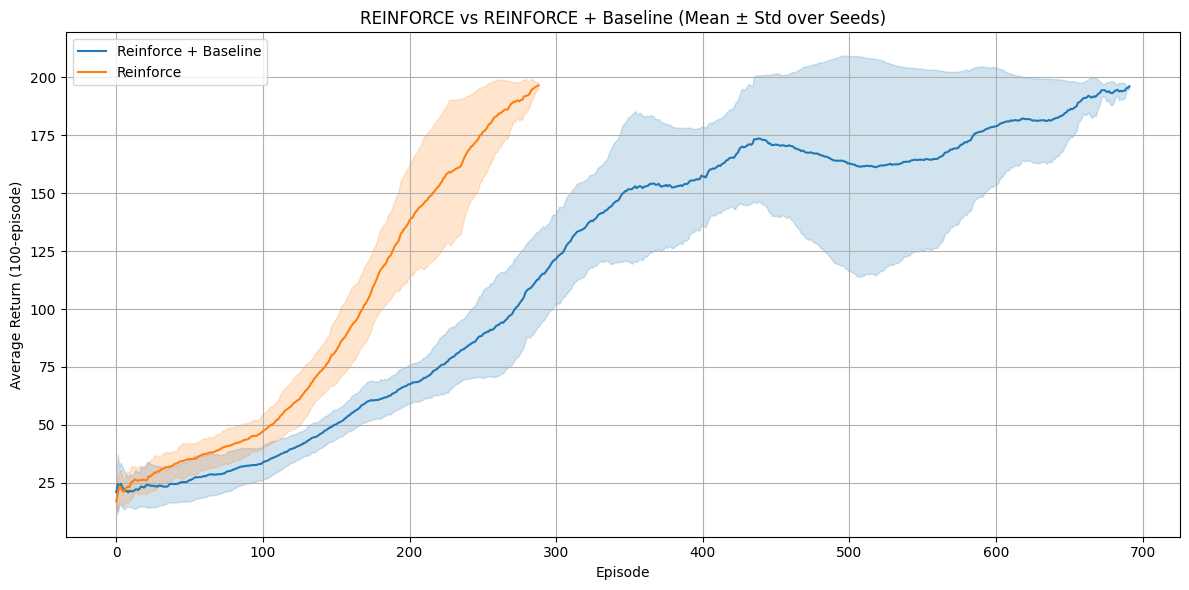

In [28]:
plt.figure(figsize=(12, 6))
x = np.arange(len(mean_rewards_baseline))

plt.plot(x, mean_rewards_baseline, label="Reinforce + Baseline", color="tab:blue")
plt.fill_between(x, mean_rewards_baseline - std_rewards_baseline, 
                mean_rewards_baseline + std_rewards_baseline, alpha=0.2, color="tab:blue")

x = np.arange(len(mean_rewards))
plt.plot(x, mean_rewards, label="Reinforce", color="tab:orange")
plt.fill_between(x, mean_rewards - std_rewards, 
                mean_rewards + std_rewards, alpha=0.2, color="tab:orange")

plt.xlabel("Episode")
plt.ylabel("Average Return (100-episode)")
plt.title("REINFORCE vs REINFORCE + Baseline (Mean ± Std over Seeds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Reinforce_CartPole.png")
plt.show()
    